In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sunpy.map
from sunpy.time import parse_time
from astropy.io import fits
from astropy.time import Time
import astropy.stats
import math
import os
import threading
from multiprocessing import Pool
import shutil
import sys
import datetime
from sklearn import preprocessing
from pathlib import Path
import cv2
import random
from scipy.ndimage import rotate

sys.path.append(os.path.join(Path.cwd(), 'utils'))

from utils.im_utils import *
from utils.data_augmentation import *

In [58]:
pd.options.display.max_columns = None

In [59]:
FLARE_CLASS = 'ALL'
ANGSTROM = '0094'        # 0094/1600/bz
EUV_CHANNEL = 'AIA'      # AIA/HMI

AIA_DATA_DIR = '../data' # ../data or ../data/data_1600 or ../data/data_HMI_bz

EVENTS_BY_DATE_DIR = './event_records/new_events_by_date'
EVENTS_BY_CLASS_DIR = './event_records/new_events_by_class'

TRAIN_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_data/train/positive'
TRAIN_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_data/train/negative'
TEST_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_data/test/positive'
TEST_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_data/test/negative'
VAL_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_data/val/positive'
VAL_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_data/val/negative'

AUG_TRAIN_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_data_augmented/train/positive'
AUG_TRAIN_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_data_augmented/train/negative'
AUG_TEST_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_data_augmented/test/positive'
AUG_TEST_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_data_augmented/test/negative'
AUG_VAL_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_data_augmented/val/positive'
AUG_VAL_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_data_augmented/val/negative'

AUG_PAIR_TRAIN_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_data_augmented_pair/train/positive'
AUG_PAIR_TRAIN_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_data_augmented_pair/train/negative'
AUG_PAIR_TEST_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_data_augmented_pair/test/positive'
AUG_PAIR_TEST_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_data_augmented_pair/test/negative'
AUG_PAIR_VAL_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_data_augmented_pair/val/positive'
AUG_PAIR_VAL_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_data_augmented_pair/val/negative'

LSTM_TRAIN_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data/train/positive'
LSTM_TRAIN_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data/train/negative'
LSTM_TEST_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data/test/positive'
LSTM_TEST_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data/test/negative'
LSTM_VAL_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data/val/positive'
LSTM_VAL_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data/val/negative'

LSTM_TRAIN_DATA_EXT_POSITIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended/train/positive'
LSTM_TRAIN_DATA_EXT_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended/train/negative'
LSTM_TEST_DATA_EXT_POSITIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended/test/positive'
LSTM_TEST_DATA_EXT_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended/test/negative'
LSTM_VAL_DATA_EXT_POSITIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended/val/positive'
LSTM_VAL_DATA_EXT_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended/val/negative'

LSTM_AUG_PAIR_TRAIN_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_pair/train/positive'
LSTM_AUG_PAIR_TRAIN_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_pair/train/negative'
LSTM_AUG_PAIR_TEST_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_pair/test/positive'
LSTM_AUG_PAIR_TEST_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_pair/test/negative'
LSTM_AUG_PAIR_VAL_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_pair/val/positive'
LSTM_AUG_PAIR_VAL_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_pair/val/negative'

LSTM_AUG_ALL_CLASS_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented/train/'
LSTM_AUG_ALL_CLASS_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented/val/'

LSTM_ALL_CLASS_PRIOR_DATA_DIR = f'./new_data/{FLARE_CLASS}_lstm_data_prior'
LSTM_ALL_CLASS_DURING_DATA_DIR = f'./new_data/{FLARE_CLASS}_lstm_data_during'
LSTM_ALL_CLASS_LATESTART_DATA_DIR = f'./new_data/{FLARE_CLASS}_lstm_data_latestart'
LSTM_ALL_CLASS_PRIOR_LEFTOUT2013_DATA_DIR = f'./new_data/{FLARE_CLASS}_lstm_data_prior_leftout2013'
LSTM_ALL_CLASS_POST_LEFTOUT2013_DATA_DIR = f'./new_data/{FLARE_CLASS}_lstm_data_post_leftout2013'

LSTM_END_AUG_PAIR_TRAIN_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_lstm_end_data_augmented_pair/train/positive'
LSTM_END_AUG_PAIR_TRAIN_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_lstm_end_data_augmented_pair/train/negative'
LSTM_END_AUG_PAIR_VAL_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_lstm_end_data_augmented_pair/val/positive'
LSTM_END_AUG_PAIR_VAL_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_lstm_end_data_augmented_pair/val/negative'

PAIR_TRAIN_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_full_image_data/train/positive'
PAIR_TRAIN_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_full_image_data/train/negative'
PAIR_VAL_DATA_POSITIVE_DIR = f'./data/{FLARE_CLASS}_full_image_data/val/positive'
PAIR_VAL_DATA_NEGATIVE_DIR = f'./data/{FLARE_CLASS}_full_image_data/val/negative'

In [60]:
CDELT = 0.599733;
HPCCENTER = 4096.0 / 2.0;
rsun_meters = 696000;
dsun_meters = 149600000;
DEFAULT_WIDTH, DEFAULT_HEIGHT = 64, 64
IMAGE_WIDTH, IMAGE_HEIGHT = 512, 512

In [61]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [62]:
def delete_data():
    delete_files(TRAIN_DATA_POSITIVE_DIR)
    delete_files(TRAIN_DATA_NEGATIVE_DIR)
    delete_files(TEST_DATA_POSITIVE_DIR)
    delete_files(TEST_DATA_NEGATIVE_DIR)
    delete_files(VAL_DATA_POSITIVE_DIR)
    delete_files(VAL_DATA_NEGATIVE_DIR)

In [63]:
def delete_lstm_data():
    delete_files(LSTM_TRAIN_DATA_POSITIVE_DIR)
    delete_files(LSTM_TRAIN_DATA_NEGATIVE_DIR)
    delete_files(LSTM_TEST_DATA_POSITIVE_DIR)
    delete_files(LSTM_TEST_DATA_NEGATIVE_DIR)
    delete_files(LSTM_VAL_DATA_POSITIVE_DIR)
    delete_files(LSTM_VAL_DATA_NEGATIVE_DIR)

In [64]:
def delete_pair_data():
    delete_files(PAIR_TRAIN_DATA_POSITIVE_DIR)
    delete_files(PAIR_TRAIN_DATA_NEGATIVE_DIR)
    delete_files(PAIR_VAL_DATA_POSITIVE_DIR)
    delete_files(PAIR_VAL_DATA_NEGATIVE_DIR)

In [65]:
def delete_augmented_data():
    delete_files(AUG_TRAIN_DATA_POSITIVE_DIR)
    delete_files(AUG_TRAIN_DATA_NEGATIVE_DIR)
    delete_files(AUG_TEST_DATA_POSITIVE_DIR)
    delete_files(AUG_TEST_DATA_NEGATIVE_DIR)
    delete_files(AUG_VAL_DATA_POSITIVE_DIR)
    delete_files(AUG_VAL_DATA_NEGATIVE_DIR)

In [66]:
def delete_augmented_pair_data():
    delete_files(AUG_PAIR_TRAIN_DATA_POSITIVE_DIR)
    delete_files(AUG_PAIR_TRAIN_DATA_NEGATIVE_DIR)
    delete_files(AUG_PAIR_TEST_DATA_POSITIVE_DIR)
    delete_files(AUG_PAIR_TEST_DATA_NEGATIVE_DIR)
    delete_files(AUG_PAIR_VAL_DATA_POSITIVE_DIR)
    delete_files(AUG_PAIR_VAL_DATA_NEGATIVE_DIR)

In [67]:
def delete_lstm_augmented_pair_data():
    delete_files(LSTM_AUG_PAIR_TRAIN_DATA_POSITIVE_DIR)
    delete_files(LSTM_AUG_PAIR_TRAIN_DATA_NEGATIVE_DIR)
    delete_files(LSTM_AUG_PAIR_VAL_DATA_POSITIVE_DIR)
    delete_files(LSTM_AUG_PAIR_VAL_DATA_NEGATIVE_DIR)

In [68]:
def delete_lstm_end_augmented_pair_data():
    delete_files(LSTM_END_AUG_PAIR_TRAIN_DATA_POSITIVE_DIR)
    delete_files(LSTM_END_AUG_PAIR_TRAIN_DATA_NEGATIVE_DIR)
    delete_files(LSTM_END_AUG_PAIR_VAL_DATA_POSITIVE_DIR)
    delete_files(LSTM_END_AUG_PAIR_VAL_DATA_NEGATIVE_DIR)

In [69]:
def reset_data_dir(data_dir):
    delete_files(os.path.join(data_dir, 'train'))
    delete_files(os.path.join(data_dir, 'val'))

In [70]:
def GenerateAugmentedLSTMData(paths, coord, sample_mult):
    full_images = [np.load(im)['x'] for im in paths]
    large_cutouts = []
    for full_im in full_images:
        large_cutouts.append(GetSafeCenteredCutout(full_im, 128, coord))
        
    rot_data = np.array([GenerateRotateData(im, sample_mult, 64) for im in large_cutouts])
    rot_data_arranged = []
    for i in range(rot_data.shape[0]):
        rot_data_arranged.append([rot_data[i][x] for x in range(rot_data.shape[1])])
    rot_data_arranged = np.array(rot_data_arranged)
    
    return rot_data_arranged#np.concatenate((rot_data, flip_data, zoom_data))

In [71]:
test_data = [
    '../data/2016/01/01/AIA20160101_0000_0094.npz',
    '../data/2016/01/01/AIA20160101_0006_0094.npz',
    '../data/2016/01/01/AIA20160101_0012_0094.npz',
    '../data/2016/01/01/AIA20160101_0018_0094.npz',
    '../data/2016/01/01/AIA20160101_0024_0094.npz',
    '../data/2016/01/01/AIA20160101_0030_0094.npz',
]

In [72]:
test = GenerateAugmentedLSTMData(test_data, (20, 100), 60)
test = np.reshape(test, (60, 6, 64, 64))

In [73]:
data = []
num = 0
for subdir, dirs, files in os.walk(f'./data/M_lstm_data_augmented_pair/train/positive/AIA20111031_1721_0094/20/sequence'):
    for f in files:
        data.append(os.path.join(subdir, f))
full_data = []
for subdir, dirs, files in os.walk(f'./data/M_lstm_data_augmented_pair/train/positive/AIA20111031_1721_0094/0/full'):
    for f in files:
        full_data.append(os.path.join(subdir, f))
data = [np.load(x) for x in data]
full_data = [np.load(x) for x in full_data]

In [74]:
def CreateNoFlareCSV(csv_to_copy):
    df = pd.read_csv(csv_to_copy)
    copy_df = df.copy()
    
    for index, row in copy_df.iterrows():
        old_starttime, old_endtime = parse_time(row['event_starttime'], precision=0), parse_time(row['event_endtime'], precision=0)
        new_starttime, new_endtime = old_starttime + datetime.timedelta(minutes=-60), old_endtime + datetime.timedelta(minutes=-60)
        copy_df.at[index,'event_starttime'] = new_starttime
        copy_df.at[index,'event_endtime'] = new_endtime
        copy_df.at[index,'fl_goescls'] = 'N0.0'
    
    copy_df.to_csv('./event_records/new_events_by_class/N.csv', index=False)

In [75]:
CreateNoFlareCSV('./event_records/new_events_by_class/M.csv')

In [76]:
def GetAIAFormatFilename(dt):
    AIA_data_date = f'{dt.year}{dt.month:02d}{dt.day:02d}'
    AIA_data_time = f'{dt.hour:02d}{dt.minute:02d}'
    AIA_data_filename = f'{EUV_CHANNEL}{AIA_data_date}_{AIA_data_time}_{ANGSTROM}'
    
    return AIA_data_filename

In [77]:
# returns a formatted file name of the closest AIA data file to the given datetime

def GetClosestDataFileByDate(dt, rounding):
    AIA_data_date = f'{dt.year}{dt.month:02d}{dt.day:02d}'
    tmp_dt = dt
    minute = 0
    minute=GetClosestMultiple(tmp_dt.minute, 6)
    AIA_data_time = f'{tmp_dt.hour:02d}{minute:02d}'
    AIA_data_filename = f'{EUV_CHANNEL}{AIA_data_date}_{AIA_data_time}_{ANGSTROM}.npz'
    
    return AIA_data_filename

In [78]:
def GetCutout(im, coord, N=64):
    x_end_idx = int(coord[0]+N)
    y_end_idx = int(coord[1]+N)
    cutout_array = im[int(coord[0]):x_end_idx, int(coord[1]):y_end_idx]
    
    return cutout_array

In [79]:
def GetCenteredCutout(im, coord, N=64):
    x, y = int(coord[0]), int(coord[1])
    offset = N//2
    x_start, x_end = x-offset, x+offset
    y_start, y_end = y-offset, y+offset
    cutout_array = im[x_start:x_end, y_start:y_end]
    
    return cutout_array

In [80]:
# returns an NxN cutout of a file centered around the given coordinate

def GetFileCutout(path, coord, N=64):
    im = np.load(path)['x']
    # scs = astropy.stats.sigma_clipped_stats(im)
    # mean, median, sd = scs[0], scs[1], scs[2]
    # thr = median+sd*3
    # im[im<thr]=0
    
    return GetCutout(im, coord, N)

In [81]:
# returns an AIA filepath closest to the provided

def GetAIAPathAtTime(dt):
    dt_data_dir = os.path.join(AIA_DATA_DIR, f'{dt.year}/{dt.month:02d}/{dt.day:02d}')
    closest_data_file = GetClosestDataFileByDate(dt, "up")
    file_path = os.path.join(dt_data_dir, closest_data_file)
    if not os.path.exists(file_path):
        raise FileNotFoundError
    
    return file_path

In [82]:
def CreateAugmentedCutouts(coord, path, save_path, rotation_step=12):
    # create augmented cutouts which are rotated, flipped, and mirrored
    cutout =  GetFileCutout(path, coord, N=128)
    return cutout
    cur_rot = rotation_step
    for i in range(360//rotation_step):
        rot_image = rotate(cutout, 0)
        rot_cutout = GetCenteredCutout(rot_image, (rot_image.shape[0]//2, rot_image.shape[1]//2), 64)
        cur_rot += rotation_step
        return rot_cutout
    
    

In [83]:
# returns M consecutive (forward or backward) AIA filepaths starting at time closest to the given time

def GetAIANCutoutsPaths(start_dt, direction='backward', M=6, cadence=6):
    cutouts_paths = []
    if direction == 'backward':
        cadence = -cadence
    dynamic_dt = start_dt
        
    for i in range(M):
        try:
            cutout_path = GetAIAPathAtTime(dynamic_dt)
        except FileNotFoundError:
            dynamic_dt = dynamic_dt + datetime.timedelta(minutes=cadence)
            continue
        cutouts_paths.append(cutout_path)
        dynamic_dt = dynamic_dt + datetime.timedelta(minutes=cadence)
    
    cutouts_paths = sorted(cutouts_paths)
    num_paths = len(cutouts_paths)
    filled_paths = cutouts_paths

    if num_paths != M:
        diff = abs(M-num_paths)
        for i in range(num_paths, num_paths-diff, -1):
            filled_paths.insert(i-1, filled_paths[i-1])
        filled_paths = sorted(filled_paths)
    filled_paths = sorted(filled_paths)
    return np.array(filled_paths)

In [84]:
# saves directional sequences of NxN cutouts of all events in the csv file to folders with start times as names

def SaveAIANCutoutsFromDF(df, save_dir, time_delta, num_frames=1, direction='backward', flare_class='all'):
    nonexistent = 0
    for index, row in df.iterrows():
        raw_time, goes_cls = parse_time(row['event_starttime'], precision=0), row['fl_goescls'][0]
        if flare_class != 'all':
            if goes_cls != flare_class:
                continue
        start_dt, y, x = raw_time.datetime, int(row['hpc_x']), int(row['hpc_y'])
        prior_dt = start_dt + datetime.timedelta(minutes=time_delta)
        coord = ConvertHPCToPixXY((x, y))
        coord = ResizeCoord(coord)
        coord = (coord[0]-32, 512-coord[1]-32)
        
        closest_file_name = GetClosestDataFileByDate(prior_dt, rounding='up')
        closest_file_path = f'{AIA_DATA_DIR}/{prior_dt.year}/{prior_dt.month:02}/{prior_dt.day:02}/{closest_file_name}'

        if not os.path.exists(closest_file_path):
            nonexistent+=1
            continue
        
        paths = GetAIANCutoutsPaths(prior_dt, direction=direction, M=num_frames, cadence=6)
        if len(paths) != num_frames:
            print(start_dt)
            print(len(paths))
        mod_save_dir = save_dir
        
        if len(paths) == 0:
            print('0 paths')
            continue
        
        if len(paths) > 1:
            folder_name = GetAIAFormatFilename(start_dt)
            event_folder_path = os.path.join(save_dir, folder_name)
            if not os.path.exists(event_folder_path):
                os.makedirs(event_folder_path)
            else:
                print(f'trying to create existing folder, time: {start_dt}')
                continue 
            mod_save_dir = event_folder_path
        for idx, p in enumerate(paths):
            cutout = GetFileCutout(p, coord)
            save_filename = os.path.basename(p).rsplit('.', 1)[0]
            np.save(f'{mod_save_dir}/{save_filename}_{idx}', cutout)

In [85]:
# saves directional sequences of NxN cutouts of all events in the csv file to folders with start times as names

def SaveAIAPairFromDF(df, save_dir, time_delta, num_frames=1, direction='backward', flare_class='all'):
    nonexistent = 0
    for index, row in df.iterrows():
        raw_time, goes_cls = parse_time(row['event_starttime'], precision=0), row['fl_goescls'][0]
        if flare_class != 'all':
            if goes_cls != flare_class:
                continue
        start_dt, y, x = raw_time.datetime, int(row['hpc_x']), int(row['hpc_y'])
        prior_dt = start_dt + datetime.timedelta(minutes=time_delta)
        coord = ConvertHPCToPixXY((x, y))
        coord = ResizeCoord(coord)
        coord = (coord[0]-32, 512-coord[1]-32)
        
        closest_file_name = GetClosestDataFileByDate(prior_dt, rounding='up')
        # full sun image path
        closest_file_path = f'{AIA_DATA_DIR}/{prior_dt.year}/{prior_dt.month:02}/{prior_dt.day:02}/{closest_file_name}'

        if not os.path.exists(closest_file_path):
            nonexistent+=1
            continue
        
        paths = GetAIANCutoutsPaths(prior_dt, direction=direction, M=num_frames, cadence=6)
        if len(paths) != num_frames:
            print(start_dt)
            print(len(paths))
        mod_save_dir = save_dir
        
        if len(paths) == 0:
            print('0 paths')
            continue
            
        folder_name = GetAIAFormatFilename(start_dt)
        event_folder_path = os.path.join(save_dir, folder_name)
        if not os.path.exists(event_folder_path):
            os.makedirs(event_folder_path)
        else:
            print(f'trying to create existing folder, time: {start_dt}')
            continue 
        mod_save_dir = event_folder_path
        for idx, p in enumerate(paths):
            cutout = GetFileCutout(p, coord)
            save_filename = os.path.basename(p).rsplit('.', 1)[0]
            np.save(f'{mod_save_dir}/{save_filename}_{idx}', cutout)
            
            full_image = np.load(closest_file_path)['x']
            full_image = cv2.resize(full_image, (128, 128), interpolation = cv2.INTER_AREA)
            scs = astropy.stats.sigma_clipped_stats(full_image)
            mean, median, sd = scs[0], scs[1], scs[2]
            thr = median+sd*3
            full_image[full_image<thr]=0
            np.save(f'{mod_save_dir}/{save_filename}_full', full_image)

In [86]:
## saves directional sequences of NxN cutouts of all events in the csv file to folders with start times as names

def SaveAIAPairFromDF(df, save_dir, time_delta, num_frames=1, direction='backward', flare_class='all'):
    nonexistent = 0
    for index, row in df.iterrows():
        raw_time, goes_cls = parse_time(row['event_starttime'], precision=0), row['fl_goescls'][0]
        if flare_class != 'all':
            if goes_cls != flare_class:
                continue
        start_dt, y, x = raw_time.datetime, int(row['hpc_x']), int(row['hpc_y'])
        prior_dt = start_dt + datetime.timedelta(minutes=time_delta)
        coord = ConvertHPCToPixXY((x, y))
        coord = ResizeCoord(coord)
        coord = (coord[0]-32, 512-coord[1]-32)
        
        closest_file_name = GetClosestDataFileByDate(prior_dt, rounding='up')
        # full sun image path
        closest_file_path = f'{AIA_DATA_DIR}/{prior_dt.year}/{prior_dt.month:02}/{prior_dt.day:02}/{closest_file_name}'

        if not os.path.exists(closest_file_path):
            nonexistent+=1
            continue
        
        paths = GetAIANCutoutsPaths(prior_dt, direction=direction, M=num_frames, cadence=6)
        if len(paths) != num_frames:
            print(start_dt)
            print(len(paths))
        mod_save_dir = save_dir
        
        if len(paths) == 0:
            print('0 paths')
            continue
            
        folder_name = GetAIAFormatFilename(start_dt)
        event_folder_path = os.path.join(save_dir, folder_name)
        if not os.path.exists(event_folder_path):
            os.makedirs(event_folder_path)
        else:
            print(f'trying to create existing folder, time: {start_dt}')
            continue 
        mod_save_dir = event_folder_path
        for idx, p in enumerate(paths):
            cutout = GetFileCutout(p, coord)
            save_filename = os.path.basename(p).rsplit('.', 1)[0]
            np.save(f'{mod_save_dir}/{save_filename}_{idx}', cutout)
            
            full_image = np.load(closest_file_path)['x']
            full_image = cv2.resize(full_image, (128, 128), interpolation = cv2.INTER_AREA)
            scs = astropy.stats.sigma_clipped_stats(full_image)
            mean, median, sd = scs[0], scs[1], scs[2]
            thr = median+sd*3
            full_image[full_image<thr]=0
            np.save(f'{mod_save_dir}/{save_filename}_full', full_image)

In [87]:
def SaveAIAAugmentedDataFromDF(df, save_dir, time_delta, num_frames=1, sample_mult=60, direction='backward', flare_class='all'):
    nonexistent = 0
    for index, row in df.iterrows():
        raw_time, goes_cls = parse_time(row['event_starttime'], precision=0), row['fl_goescls'][0]
        if flare_class != 'all':
            if goes_cls != flare_class:
                continue
        start_dt, y, x = raw_time.datetime, int(row['hpc_x']), int(row['hpc_y'])
        prior_dt = start_dt + datetime.timedelta(minutes=time_delta)
        coord = ConvertHPCToPixXY((x, y))
        coord = ResizeCoord(coord)
        coord = (coord[0], 512-coord[1])
        
        closest_file_name = GetClosestDataFileByDate(prior_dt, rounding='up')
        closest_file_path = f'{AIA_DATA_DIR}/{prior_dt.year}/{prior_dt.month:02}/{prior_dt.day:02}/{closest_file_name}'
        if not os.path.exists(closest_file_path):
            nonexistent+=1
            continue
        
        paths = GetAIANCutoutsPaths(prior_dt, direction=direction, M=num_frames, cadence=6)
        if len(paths) != num_frames:
            print(start_dt)
            print(len(paths))
        mod_save_dir = save_dir
        
        if len(paths) == 0:
            print('0 paths')
            continue
        
        for idx, p in enumerate(paths):
            full_image = np.load(closest_file_path)['x']
            aug_data = GenerateAugmentedData(full_image, coord, sample_mult)
            aug_data = np.concatenate((aug_data))
            for idx, d in enumerate(aug_data):
                folder_name = GetAIAFormatFilename(start_dt)
                event_folder_path = f'{os.path.join(save_dir, folder_name)}_{idx}'
                if not os.path.exists(event_folder_path):
                    os.makedirs(event_folder_path)
                else:
                    print(f'trying to create existing folder, time: {start_dt}')
                    continue 
                mod_save_dir = event_folder_path
                save_filename = os.path.basename(p).rsplit('.', 1)[0]
                np.save(f'{mod_save_dir}/{save_filename}_augmented_{idx}', d)
                np.save(f'{mod_save_dir}/{save_filename}_full', full_image)

In [88]:
# saves directional sequences of NxN cutouts of all events in the csv file to folders with start times as names

def SaveAIANAugmentedDataFromDF(df, save_dir, time_delta, positive=True, num_frames=1, sample_mult=60, direction='backward', flare_class='all'):
    nonexistent = 0
    for index, row in df.iterrows():
        # if not positive:
        #     time_delta = -18
            # time_delta = random.choice([-36, 12])
        raw_time, goes_cls = parse_time(row['event_starttime'], precision=0), row['fl_goescls'][0]
        if flare_class != 'all':
            if goes_cls != flare_class:
                continue
        start_dt, y, x = raw_time.datetime, int(row['hpc_x']), int(row['hpc_y'])
        prior_dt = start_dt + datetime.timedelta(minutes=time_delta)
        coord = ConvertHPCToPixXY((x, y))
        coord = ResizeCoord(coord)
        coord = (coord[0], 512-coord[1])
        
        closest_file_name = GetClosestDataFileByDate(prior_dt, rounding='up')
        closest_file_path = f'{AIA_DATA_DIR}/{prior_dt.year}/{prior_dt.month:02}/{prior_dt.day:02}/{closest_file_name}'

        if not os.path.exists(closest_file_path):
            nonexistent+=1
            continue
            
        paths = GetAIANCutoutsPaths(prior_dt, direction=direction, M=num_frames, cadence=6)
        if len(paths) != num_frames:
            print(start_dt)
            print(len(paths))
        mod_save_dir = save_dir
        
        if len(paths) == 0:
            print('0 paths')
            continue
            
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        paths = sorted(paths)
            
        aug_data = GenerateAugmentedLSTMData(paths, coord, sample_mult)
        full_images = [np.load(im)['x'] for im in paths]
        full_image_aug_data = np.array([GenerateRotateData(im, sample_mult, 512) for im in full_images])

        folder_name = GetAIAFormatFilename(start_dt)
        event_folder_path = os.path.join(save_dir, folder_name)
        for i in range(aug_data.shape[1]):
            subfolder_path = os.path.join(event_folder_path, str(i))
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)
            sequence_folder_path = os.path.join(subfolder_path, 'sequence')
            if not os.path.exists(sequence_folder_path):
                os.makedirs(sequence_folder_path)
            full_images_folder_path = os.path.join(subfolder_path, 'full')
            if not os.path.exists(full_images_folder_path):
                os.makedirs(full_images_folder_path)
            for j in range(aug_data.shape[0]):
                aia_filename = paths[j].rsplit('/', 1)[-1].rsplit('.', 1)[0]
                save_filename = f'{aia_filename}_{j}'
                np.save(f'{sequence_folder_path}/{save_filename}', aug_data[j][i])
                np.save(f'{full_images_folder_path}/{save_filename}', full_image_aug_data[j][i])

In [89]:
###### saves directional sequences of NxN cutouts of all events in the csv file to folders with start times as names

def SaveAIAAllClassAugmentedDataFromDF(df, save_dir, time_delta, num_frames=1, sample_mult=None, direction='backward', starting_point='event_starttime', cadence=6):
    # C: 6127 M: 612 X: 38
    # multiplied by 2, 20, 320
    # C: 12,254 M: 12,240 X: 12,160
    print('started SaveAIAAllClassAugmentedDataFromDF')
    nonexistent = 0
    for index, row in df.iterrows():
        raw_time, goes_cls = parse_time(row[starting_point], precision=0), row['fl_goescls'][0]
        cur_save_dir = os.path.join(save_dir, goes_cls)
        if not os.path.exists(cur_save_dir):
            os.makedirs(cur_save_dir)
            
        start_dt, y, x = raw_time.datetime, int(row['hpc_x']), int(row['hpc_y'])
        prior_dt = start_dt + datetime.timedelta(minutes=time_delta)
        coord = ConvertHPCToPixXY((x, y))
        coord = ResizeCoord(coord)
        coord = (coord[0], 512-coord[1])
        
        closest_file_name = GetClosestDataFileByDate(prior_dt, rounding='up')
        closest_file_path = f'{AIA_DATA_DIR}/{prior_dt.year}/{prior_dt.month:02}/{prior_dt.day:02}/{closest_file_name}'
        
        if not os.path.exists(closest_file_path):
            nonexistent+=1
            continue
            
        paths = GetAIANCutoutsPaths(prior_dt, direction=direction, M=num_frames, cadence=cadence)
        
        if len(paths) != num_frames:
            print(start_dt)
            print(len(paths))
        
        if len(paths) == 0:
            print('0 paths')
            continue
        
        if sample_mult == None:
            if goes_cls == 'N':
                sample_mult = 30
            elif goes_cls == 'C':
                sample_mult = 2   
            elif goes_cls == 'M':
                sample_mult = 30
            elif goes_cls == 'X':
                sample_mult = 350
        aug_data = GenerateAugmentedLSTMData(paths, coord, sample_mult)
        full_images = [np.load(im)['x'] for im in paths]
        full_image_aug_data = np.array([GenerateRotateData(im, sample_mult, 512) for im in full_images])

        folder_name = GetAIAFormatFilename(start_dt)
        event_folder_path = os.path.join(cur_save_dir, folder_name)
        for i in range(aug_data.shape[1]):
            subfolder_path = os.path.join(event_folder_path, str(i))
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)
            sequence_folder_path = os.path.join(subfolder_path, 'sequence')
            if not os.path.exists(sequence_folder_path):
                os.makedirs(sequence_folder_path)
            full_images_folder_path = os.path.join(subfolder_path, 'full')
            if not os.path.exists(full_images_folder_path):
                os.makedirs(full_images_folder_path)
            for j in range(aug_data.shape[0]):
                aia_filename = paths[j].rsplit('/', 1)[-1].rsplit('.', 1)[0]
                save_filename = f'{aia_filename}_{j}'
                np.save(f'{sequence_folder_path}/{save_filename}', aug_data[j][i])
                np.save(f'{full_images_folder_path}/{save_filename}', full_image_aug_data[j][i])

In [90]:
###### saves directional sequences of NxN cutouts of all events in the csv file to folders with start times as names

def SaveAIABinaryAugmentedDataFromDF(df, save_dir, time_delta, num_frames=1, sample_mult=None, direction='backward', starting_point='event_starttime', cadence=6):
    # C: 6127 M: 612 X: 38
    # multiplied by 2, 20, 320
    # C: 12,254 M: 12,240 X: 12,160
    
    nonexistent = 0
    pos_dir = os.path.join(save_dir, 'positive')
    neg_dir = os.path.join(save_dir, 'negative')
    if not os.path.exists(pos_dir):
        os.makedirs(pos_dir)
    if not os.path.exists(neg_dir):
        os.makedirs(neg_dir)
    
    
    
    for index, row in df.iterrows():
        raw_time, goes_cls = parse_time(row[starting_point], precision=0), row['fl_goescls'][0]
            
        start_dt, y, x = raw_time.datetime, int(row['hpc_x']), int(row['hpc_y'])
        prior_dt = start_dt + datetime.timedelta(minutes=time_delta)
        coord = ConvertHPCToPixXY((x, y))
        coord = ResizeCoord(coord)
        coord = (coord[0], 512-coord[1])
        
        closest_file_name = GetClosestDataFileByDate(prior_dt, rounding='up')
        closest_file_path = f'{AIA_DATA_DIR}/{prior_dt.year}/{prior_dt.month:02}/{prior_dt.day:02}/{closest_file_name}'

        if not os.path.exists(closest_file_path):
            nonexistent+=1
            continue
            
        paths = GetAIANCutoutsPaths(prior_dt, direction=direction, M=num_frames, cadence=cadence)
        
        if len(paths) != num_frames:
            print(start_dt)
            print(len(paths))
        
        if len(paths) == 0:
            print('0 paths')
            continue
        
        if sample_mult == None:
            if goes_cls == 'N':
                sample_mult = 40
            elif goes_cls == 'C':
                sample_mult = 1   
            elif goes_cls == 'M':
                sample_mult = 10
            elif goes_cls == 'X':
                sample_mult = 250
        aug_data = GenerateAugmentedLSTMData(paths, coord, sample_mult)
        full_images = [np.load(im)['x'] for im in paths]
        full_image_aug_data = np.array([GenerateRotateData(im, sample_mult, 512) for im in full_images])

        cur_save_dir = pos_dir
        if goes_cls == 'N':
            cur_save_dir = neg_dir
        
        folder_name = GetAIAFormatFilename(start_dt)
        event_folder_path = os.path.join(cur_save_dir, folder_name)
        for i in range(aug_data.shape[1]):
            subfolder_path = os.path.join(event_folder_path, str(i))
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)
            sequence_folder_path = os.path.join(subfolder_path, 'sequence')
            if not os.path.exists(sequence_folder_path):
                os.makedirs(sequence_folder_path)
            full_images_folder_path = os.path.join(subfolder_path, 'full')
            if not os.path.exists(full_images_folder_path):
                os.makedirs(full_images_folder_path)
            for j in range(aug_data.shape[0]):
                aia_filename = paths[j].rsplit('/', 1)[-1].rsplit('.', 1)[0]
                save_filename = f'{aia_filename}_{j}'
                np.save(f'{sequence_folder_path}/{save_filename}', aug_data[j][i])
                np.save(f'{full_images_folder_path}/{save_filename}', full_image_aug_data[j][i])

In [91]:
def CreateResnetData(test_split=0.25, val_split=0.15, classes='all'):
    delete_data()
    train_split = 1-test_split+val_split
    
    for subdir, dirs, files in os.walk(EVENTS_BY_CLASS_DIR):
        for file in files:
            if classes != 'all':
                if file.rsplit('.', 1)[0] != classes:
                    continue
            print(file.rsplit('.', 1)[0])
            class_df = pd.read_csv(os.path.join(subdir, file))
            CreateResnetDataOfClass(class_df, test_split, val_split, classes)

In [92]:
def CreateLSTMData(val_split=0.3, classes='all'):
    delete_lstm_data()
    train_split = 1-val_split
    
    for subdir, dirs, files in os.walk(EVENTS_BY_CLASS_DIR):
        for file in files:
            if classes != 'all':
                if file.rsplit('.', 1)[0] != classes:
                    continue
            print(file.rsplit('.', 1)[0])
            class_df = pd.read_csv(os.path.join(subdir, file))
            CreateLSTMDataOfClass(class_df, val_split, classes)

In [93]:
def CreateLSTMPairData(val_split=0.3, classes='all'):
    delete_lstm_data()
    train_split = 1-val_split
    
    for subdir, dirs, files in os.walk(EVENTS_BY_CLASS_DIR):
        for file in files:
            if classes != 'all':
                if file.rsplit('.', 1)[0] != classes:
                    continue
            print(file.rsplit('.', 1)[0])
            class_df = pd.read_csv(os.path.join(subdir, file))
            CreateLSTMPairDataOfClass(class_df, val_split, classes)

In [94]:
def CreatePairData(val_split=0.3, classes='all'):
    delete_pair_data()
    train_split = 1-val_split
    
    for subdir, dirs, files in os.walk(EVENTS_BY_CLASS_DIR):
        for file in files:
            if classes != 'all':
                if file.rsplit('.', 1)[0] != classes:
                    continue
            print(file.rsplit('.', 1)[0])
            class_df = pd.read_csv(os.path.join(subdir, file))
            CreatePairDataOfClass(class_df, val_split, classes)

In [95]:
def CreateAugmentedData(val_split=0.3, classes='all'):
    # delete_augmented_data()
    delete_augmented_pair_data()
    train_split = 1-val_split
    
    for subdir, dirs, files in os.walk(EVENTS_BY_CLASS_DIR):
        for file in files:
            if classes != 'all':
                if file.rsplit('.', 1)[0] != classes:
                    continue
            print(file.rsplit('.', 1)[0])
            class_df = pd.read_csv(os.path.join(subdir, file))
            CreateAugmentedDataOfClass(class_df, val_split, classes)

In [96]:
def CreateAugmentedLSTMData(val_split=0.3, classes='all'):
    # delete_augmented_data()
    delete_lstm_augmented_pair_data()
    train_split = 1-val_split
    
    for subdir, dirs, files in os.walk(EVENTS_BY_CLASS_DIR):
        for file in files:
            if classes != 'all':
                if file.rsplit('.', 1)[0] != classes:
                    continue
            print(file.rsplit('.', 1)[0])
            class_df = pd.read_csv(os.path.join(subdir, file))
            CreateAugmentedLSTMDataOfClass(class_df, val_split, classes)

In [97]:
def CreateEndAugmentedLSTMData(val_split=0.3, classes='all'):
    delete_lstm_end_augmented_pair_data()
    train_split = 1-val_split
    
    for subdir, dirs, files in os.walk(EVENTS_BY_CLASS_DIR):
        for file in files:
            if classes != 'all':
                if file.rsplit('.', 1)[0] != classes:
                    continue
            print(file.rsplit('.', 1)[0])
            class_df = pd.read_csv(os.path.join(subdir, file))
            CreateEndAugmentedLSTMDataOfClass(class_df, val_split, classes)

In [98]:
def CreateAugmentedLSTMDataAll(save_dir, direction, val_year, starting_point='event_starttime', classes=['M', 'X', 'N'], cadence=6, time_delta=0):
    reset_data_dir(save_dir)
    event_files = []
    
    val_dfs = []
    
    p = Pool(8)
    for subdir, dirs, files in os.walk(EVENTS_BY_CLASS_DIR):
        for file in files:
            event_files.append(os.path.join(subdir, file))
    for file in event_files:
        filename = file.rsplit('/', 1)[-1].rsplit('.', 1)[0]
        if filename in classes:
            print(file.rsplit('/', 1)[-1])
            class_df = pd.read_csv(file)
            
            train_df = class_df
            val_df = None
            
            if val_year != None:
                class_df_pruned_rows = np.array([parse_time(x).datetime.year for x in class_df.event_starttime])
                train_df = class_df[class_df_pruned_rows != val_year]
                val_df = class_df[class_df_pruned_rows == val_year] 
            
            p.apply_async(CreateAugmentedLSTMDataAllClass, (save_dir, train_df, val_df, direction, starting_point, cadence, time_delta))
    p.close()
    p.join()

In [99]:
def CreateAugmentedLSTMDataBinary(save_dir, direction, val_year, starting_point='event_starttime', classes=['M', 'X', 'N'], cadence=6, time_delta=0):
    reset_data_dir(save_dir)
    event_files = []
    
    val_dfs = []
    
    p = Pool(8)
    for subdir, dirs, files in os.walk(EVENTS_BY_CLASS_DIR):
        for file in files:
            event_files.append(os.path.join(subdir, file))
    for file in event_files:
        filename = file.rsplit('/', 1)[-1].rsplit('.', 1)[0]
        if filename in classes:
            print(file.rsplit('/', 1)[-1])
            class_df = pd.read_csv(file)
            
            train_df = class_df
            val_df = None
            
            if val_year != None:
                class_df_pruned_rows = np.array([parse_time(x).datetime.year for x in class_df.event_starttime])
                train_df = class_df[class_df_pruned_rows != val_year]
                val_df = class_df[class_df_pruned_rows == val_year] 
            
            p.apply_async(CreateBinaryAugmentedLSTMData, (save_dir, train_df, val_df, direction, starting_point, cadence, time_delta))
    p.close()
    p.join()

In [100]:
def CreateResnetDataOfClass(class_df, test_split, val_split, classes='all'):
    class_df = class_df.sample(frac=1).reset_index(drop=True)
    event_num = len(class_df)
    test_split_num, val_split_num = math.ceil(event_num*test_split), math.ceil(event_num*val_split)
    test_df = class_df[-test_split_num:]
    class_df = class_df[:-test_split_num]
    val_df = class_df[-val_split_num:]
    class_df = class_df[:-val_split_num]
    time_delta = 0
    random_time_delta = -36
    
    SaveAIANCutoutsFromDF(test_df, TEST_DATA_POSITIVE_DIR, time_delta, num_frames=1, direction='forward', flare_class=classes)
    SaveAIANCutoutsFromDF(test_df, TEST_DATA_NEGATIVE_DIR, random_time_delta, num_frames=1, direction='backward', flare_class=classes)
    
    SaveAIANCutoutsFromDF(val_df, VAL_DATA_POSITIVE_DIR, time_delta, num_frames=1, direction='forward', flare_class=classes)
    SaveAIANCutoutsFromDF(val_df, VAL_DATA_NEGATIVE_DIR, random_time_delta, num_frames=1, direction='backward', flare_class=classes)
    
    SaveAIANCutoutsFromDF(class_df, TRAIN_DATA_POSITIVE_DIR, time_delta, num_frames=1, direction='forward', flare_class=classes)
    SaveAIANCutoutsFromDF(class_df, TRAIN_DATA_NEGATIVE_DIR, random_time_delta, num_frames=1, direction='backward', flare_class=classes)
    
    # print(f'total training data: {len(train_df)*2}, total val data: {len(val_df)*2}, total test data: {len(test_df)*2}')

In [101]:
def CreateLSTMDataOfClass(class_df, test_split, val_split, classes='all'):
    class_df = class_df.sample(frac=1).reset_index(drop=True)
    event_num = len(class_df)
    test_split_num, val_split_num = math.ceil(event_num*test_split), math.ceil(event_num*val_split)
    test_df = class_df[-test_split_num:]
    class_df = class_df[:-test_split_num]
    val_df = class_df[-val_split_num:]
    class_df = class_df[:-val_split_num]
    time_delta = -6
    random_mult = 6#np.random.randint(3, 7)
    random_time_delta = random_mult * time_delta
    
    SaveAIANCutoutsFromDF(test_df, LSTM_TRAIN_DATA_EXT_POSITIVE_DIR, time_delta, num_frames=20, direction='backward', flare_class=classes)
    SaveAIANCutoutsFromDF(test_df, LSTM_TEST_DATA_EXT_NEGATIVE_DIR, random_time_delta, num_frames=20, direction='backward', flare_class=classes)
    
    SaveAIANCutoutsFromDF(val_df, LSTM_VAL_DATA_EXT_POSITIVE_DIR, time_delta, num_frames=20, direction='backward', flare_class=classes)
    SaveAIANCutoutsFromDF(val_df, LSTM_VAL_DATA_EXT_NEGATIVE_DIR, random_time_delta, num_frames=20, direction='backward', flare_class=classes)
    
    SaveAIANCutoutsFromDF(class_df, LSTM_TRAIN_DATA_EXT_POSITIVE_DIR, time_delta, num_frames=20, direction='backward', flare_class=classes)
    SaveAIANCutoutsFromDF(class_df, LSTM_TRAIN_DATA_EXT_NEGATIVE_DIR, random_time_delta, num_frames=20, direction='backward', flare_class=classes)

In [102]:
def CreateLSTMPairDataOfClass(class_df, val_split, classes='all'):
    class_df = class_df.sample(frac=1).reset_index(drop=True)
    event_num = len(class_df)
    val_split_num = math.ceil(event_num*val_split)
    val_df = class_df[-val_split_num:]
    class_df = class_df[:-val_split_num]
    time_delta = 0
    random_time_delta = -36
    random_mult = 6#np.random.randint(3, 7)
    random_time_delta = random_mult * time_delta
    
    SaveAIANCutoutsFromDF(class_df, LSTM_AUG_PAIR_TRAIN_DATA_POSITIVE_DIR, time_delta, num_frames=6, direction='backward', flare_class=classes)
    SaveAIANCutoutsFromDF(class_df, LSTM_AUG_PAIR_TRAIN_DATA_NEGATIVE_DIR, random_time_delta, num_frames=6, direction='backward', flare_class=classes)
    
    SaveAIANCutoutsFromDF(val_df, LSTM_AUG_PAIR_VAL_DATA_POSITIVE_DIR, time_delta, num_frames=6, direction='backward', flare_class=classes)
    SaveAIANCutoutsFromDF(val_df, LSTM_AUG_PAIR_VAL_DATA_NEGATIVE_DIR, random_time_delta, num_frames=6, direction='backward', flare_class=classes)

In [103]:
def CreatePairDataOfClass(class_df, val_split, classes='all'):
    class_df = class_df.sample(frac=1).reset_index(drop=True)
    event_num = len(class_df)
    val_split_num = math.ceil(event_num*val_split)
    val_df = class_df[-val_split_num:]
    class_df = class_df[:-val_split_num]
    time_delta = 0
    random_time_delta = -36
    
    SaveAIAPairFromDF(class_df, PAIR_TRAIN_DATA_POSITIVE_DIR, time_delta, num_frames=1, direction='forward', flare_class=classes)
    SaveAIAPairFromDF(class_df, PAIR_TRAIN_DATA_NEGATIVE_DIR, random_time_delta, num_frames=1, direction='backward', flare_class=classes)
    
    SaveAIAPairFromDF(val_df, PAIR_VAL_DATA_POSITIVE_DIR, time_delta, num_frames=1, direction='forward', flare_class=classes)
    SaveAIAPairFromDF(val_df, PAIR_VAL_DATA_NEGATIVE_DIR, random_time_delta, num_frames=1, direction='backward', flare_class=classes)

In [104]:
def CreateAugmentedDataOfClass(class_df, val_split, classes='all'):
    class_df = class_df.sample(frac=1).reset_index(drop=True)
    event_num = len(class_df)
    val_split_num = math.ceil(event_num*val_split)
    val_df = class_df[-val_split_num:]
    class_df = class_df[:-val_split_num]
    time_delta = 0
    random_time_delta = -36
    
    SaveAIAAugmentedDataFromDF(class_df, AUG_PAIR_TRAIN_DATA_POSITIVE_DIR, time_delta, num_frames=1, sample_mult=60, direction='forward', flare_class=classes)
    SaveAIAAugmentedDataFromDF(class_df, AUG_PAIR_TRAIN_DATA_NEGATIVE_DIR, random_time_delta, num_frames=1, sample_mult=60, direction='backward', flare_class=classes)
    
    # SaveAIAAugmentedDataFromDF(val_df, AUG_VAL_DATA_POSITIVE_DIR, time_delta, num_frames=1, sample_mult=60, direction='forward', flare_class=classes)
    # SaveAIAAugmentedDataFromDF(val_df, AUG_VAL_DATA_NEGATIVE_DIR, random_time_delta, num_frames=1, sample_mult=60, direction='backward', flare_class=classes)
    # SaveAIANCutoutsFromDF(val_df, AUG_PAIR_VAL_DATA_POSITIVE_DIR, time_delta, num_frames=1, direction='forward', flare_class=classes)
    # SaveAIANCutoutsFromDF(val_df, AUG_PAIR_VAL_DATA_NEGATIVE_DIR, random_time_delta, num_frames=1, direction='backward', flare_class=classes)
    SaveAIAPairFromDF(val_df, AUG_PAIR_VAL_DATA_POSITIVE_DIR, time_delta, num_frames=1, direction='forward', flare_class=classes)
    SaveAIAPairFromDF(val_df, AUG_PAIR_VAL_DATA_NEGATIVE_DIR, random_time_delta, num_frames=1, direction='backward', flare_class=classes)

In [105]:
def CreateAugmentedLSTMDataOfClass(class_df, val_split, classes='all'):
    class_df = class_df.sample(frac=1).reset_index(drop=True)
    event_num = len(class_df)
    val_split_num = math.ceil(event_num*val_split)
    val_df = class_df[-val_split_num:]
    class_df = class_df[:-val_split_num]
    time_delta = -18
    random_time_delta = -60
    num_frames = 6
    
    SaveAIANAugmentedDataFromDF(class_df, LSTM_AUG_PAIR_TRAIN_DATA_NEGATIVE_DIR, random_time_delta, positive=False, num_frames=num_frames, sample_mult=60, direction='forward', flare_class=classes)    
    SaveAIANAugmentedDataFromDF(class_df, LSTM_AUG_PAIR_TRAIN_DATA_POSITIVE_DIR, time_delta, positive=True, num_frames=num_frames, sample_mult=60, direction='forward', flare_class=classes)
    
    SaveAIANAugmentedDataFromDF(val_df, LSTM_AUG_PAIR_VAL_DATA_POSITIVE_DIR, time_delta, positive=True, num_frames=num_frames, sample_mult=1, direction='forward', flare_class=classes)
    SaveAIANAugmentedDataFromDF(val_df, LSTM_AUG_PAIR_VAL_DATA_NEGATIVE_DIR, random_time_delta, positive=False, num_frames=num_frames, sample_mult=1, direction='forward', flare_class=classes)

In [106]:
def CreateEndAugmentedLSTMDataOfClass(class_df, val_split, classes='all'):
    class_df = class_df.sample(frac=1).reset_index(drop=True)
    event_num = len(class_df)
    val_split_num = math.ceil(event_num*val_split)
    val_df = class_df[-val_split_num:]
    class_df = class_df[:-val_split_num]
    time_delta = 6
    random_time_delta = -12#np.random.randint(0, 4)
    
    SaveAIANAugmentedDataFromDF(class_df, LSTM_END_AUG_PAIR_TRAIN_DATA_NEGATIVE_DIR, random_time_delta, num_frames=6, sample_mult=60, direction='backward', flare_class=classes)
    SaveAIANAugmentedDataFromDF(class_df, LSTM_END_AUG_PAIR_TRAIN_DATA_POSITIVE_DIR, time_delta, num_frames=6, sample_mult=60, direction='backward', flare_class=classes)
    
    SaveAIANAugmentedDataFromDF(val_df, LSTM_END_AUG_PAIR_VAL_DATA_POSITIVE_DIR, time_delta, num_frames=6, sample_mult=1, direction='backward', flare_class=classes)
    SaveAIANAugmentedDataFromDF(val_df, LSTM_END_AUG_PAIR_VAL_DATA_NEGATIVE_DIR, random_time_delta, num_frames=6, sample_mult=1, direction='backward', flare_class=classes)

In [107]:
def CreateAugmentedLSTMDataAllClass(save_dir, train_df, val_df, direction, starting_point='event_starttime', cadence=6, time_delta=0):
    print('started CreateAugmentedLSTMDataAllClass')
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    
    num_frames = 6
    train_dir = os.path.join(save_dir, 'train')
    val_dir = os.path.join(save_dir, 'val')
    
    SaveAIAAllClassAugmentedDataFromDF(train_df, train_dir, time_delta, num_frames=num_frames, sample_mult=None, direction=direction, starting_point=starting_point, cadence=cadence, time_delta=time_delta)   
    SaveAIAAllClassAugmentedDataFromDF(val_df, val_dir, time_delta, num_frames=num_frames, sample_mult=1, direction=direction, starting_point=starting_point, cadence=cadence, time_delta=time_delta)

In [108]:
def CreateBinaryAugmentedLSTMData(save_dir, train_df, val_split, direction, starting_point='event_starttime', cadence=6, time_delta=0):
    print('started CreateBinaryAugmentedLSTMData')
    train_df = train_df.sample(frac=1).reset_index(drop=True)

    num_frames = 6
    train_dir = os.path.join(save_dir, 'train')
    val_dir = os.path.join(save_dir, 'val')
    
    SaveAIABinaryAugmentedDataFromDF(train_df, train_dir, time_delta, num_frames=num_frames, sample_mult=None, direction=direction, starting_point=starting_point, cadence=cadence)   
    SaveAIABinaryAugmentedDataFromDF(val_df, val_dir, time_delta, num_frames=num_frames, sample_mult=1, direction=direction, starting_point=starting_point, cadence=cadence)

In [109]:
# ALL_lstm_data_nmx_during_leftout2013_cadence6
# ALL_lstm_data_nmx_midstart_leftout2013_cadence12
# BINARY_lstm_data_nmx_during_leftout2013_cadence12
# BINARY_lstm_data_nmx_during_leftout2013_cadence6
# BINARY_lstm_data_nmx_prior_leftout2013_cadence12
# BINARY_lstm_data_nmx_prior_leftout2013_cadence6

In [ ]:
CreateAugmentedLSTMDataAll('./new_data/ALL_lstm_data_nmx_during_leftout2013_cadence6', 'forward', 2013, 'event_starttime', ['N', 'M', 'X'], cadence=6, time_delta=0)


In [ ]:
CreateAugmentedLSTMDataAll('./new_data/ALL_lstm_data_nmx_midstart_leftout2013_cadence12', 'forward', 2013, 'event_starttime', ['N', 'M', 'X'], cadence=12, time_delta=-18)


In [ ]:
CreateAugmentedLSTMDataBinary('./new_data/BINARY_lstm_data_nmx_during_leftout2013_cadence12', 'forward', 2013, 'event_starttime', ['N', 'M', 'X'], cadence=12, time_delta=0)


started CreateBinaryAugmentedLSTMData
started CreateBinaryAugmentedLSTMData
X.csv
N.csv
M.csv
started CreateBinaryAugmentedLSTMData


In [ ]:
CreateAugmentedLSTMDataBinary('./new_data/BINARY_lstm_data_nmx_during_leftout2013_cadence6', 'forward', 2013, 'event_starttime', ['N', 'M', 'X'], cadence=6, time_delta=0)


In [ ]:
CreateAugmentedLSTMDataBinary('./new_data/BINARY_lstm_data_nmx_prior_leftout2013_cadence12', 'backward', 2013, 'event_starttime', ['N', 'M', 'X'], cadence=12, time_delta=0)


In [ ]:
CreateAugmentedLSTMDataBinary('./new_data/BINARY_lstm_data_nmx_prior_leftout2013_cadence6', 'backward', 2013, 'event_starttime', ['N', 'M', 'X'], cadence=6, time_delta=0)


In [185]:
# total_train_data = 0
# total_test_data = 0
# total_val_data = 0

# train_dir = os.path.join(LSTM_ALL_CLASS_HYBRID_DATA_DIR, 'train')
# val_dir = os.path.join(LSTM_ALL_CLASS_HYBRID_DATA_DIR, 'val')

# for subdir, dirs, files in os.walk(train_dir):
#     total_train_data += len(files)
    
# for subdir, dirs, files in os.walk(val_dir):
#     total_val_data += len(files)
    
# print(f'train data: {total_train_data} val data: {total_val_data} test data: {total_test_data}')

NameError: name 'LSTM_ALL_CLASS_HYBRID_DATA_DIR' is not defined

./data_1600/ALL_lstm_data_during_leftout2013/train/C/AIA20100815_1823_0094/0/sequence/AIA20100815_1812_0094_0.npy
./data_1600/ALL_lstm_data_during_leftout2013/train/C/AIA20100815_1823_0094/0/sequence/AIA20100815_1818_0094_1.npy
./data_1600/ALL_lstm_data_during_leftout2013/train/C/AIA20100815_1823_0094/0/sequence/AIA20100815_1824_0094_2.npy
./data_1600/ALL_lstm_data_during_leftout2013/train/C/AIA20100815_1823_0094/0/sequence/AIA20100815_1830_0094_3.npy
./data_1600/ALL_lstm_data_during_leftout2013/train/C/AIA20100815_1823_0094/0/sequence/AIA20100815_1836_0094_4.npy
./data_1600/ALL_lstm_data_during_leftout2013/train/C/AIA20100815_1823_0094/0/sequence/AIA20100815_1842_0094_5.npy


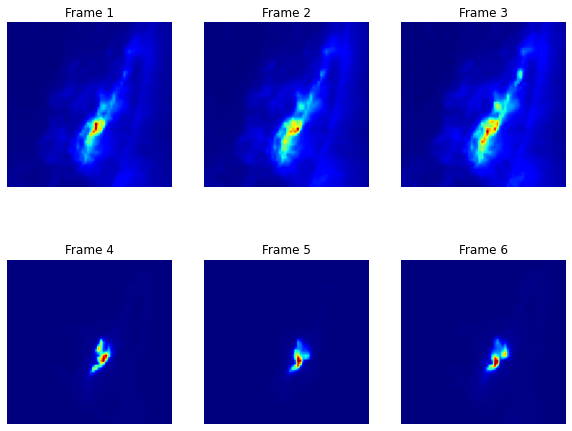

In [81]:
# data_folder = './data_1600/ALL_lstm_data_during_leftout2013/train/M/AIA20141227_0203_1600/0/full'
# paths = []
# for subdir, dirs, files in os.walk(data_folder):
#     for f in files:
#         paths.append(os.path.join(subdir, f))
# paths = sorted(paths)
# for p in paths:
#     print(p)

# fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# for idx, ax in enumerate(axes.flat):
#     ax.imshow(np.load(paths[idx]), cmap='jet')
#     ax.set_title(f"Frame {idx + 1}")
#     ax.axis("off")

# plt.show()